# Hidden Markov Models

**Authors**

[Fernando Moreno Pino](http://www.tsc.uc3m.es/~fmoreno/) and [Emese Sukei](https://github.com/semese)

Hidden Markov Models (HMMs) are a class of probabilistic graphical model that allow us to predict a sequence of unknown (hidden) variables from a set of observed variables. 

An HMM is characterised by the following:

 - $X$ - states in the model
 - $y$ - the observations
 - $A = \{a_{ij}\}$ - the state transition probabilities
 - $B = \{b_j (k)\}$ - the observation probabilities
 - $\pi$ - the initial state probabilities
    
 

The following figure shows a diagram of the probabilistic parameters of an HMM.
<img src='img/hmm_diagram.png' width='500'/>

There are three fundamental problems regarding HMMs:

- **Problem 1 (Likelihood)**: given an HMM $\lambda = (A,B)$ and an observation sequence O, determine the likelihood $P(O|\lambda)$}.  
- **Problem 2 (Decoding)**: given an HMM $\lambda = (A,B)$ and an observation sequence O, discover the best hidden state sequence.
- **Problem 3 (Learning)**: given an observation sequence O and the set of states in the HMM, learn the HMM parameters A and B.

*Reference: https://en.wikipedia.org/wiki/Hidden_Markov_model*

Based on the type of the observations, we can differentiate between HMMs with discrete observations, HMMs with continuous observations or a combination of the two. Our implementation can deal with multinomial and Gaussian observations. 

In the followings we provide examples for each type, with explanations on how to use the code in each case. 

In [1]:
# path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pickle

from heterogeneoushmm.gaussian import GaussianHMM
from heterogeneoushmm.multinomial import MultinomialHMM
from heterogeneoushmm.heterogeneous import HeterogeneousHMM
import heterogeneoushmm.utils as hu

%load_ext autoreload
%autoreload 2

# Multinomial HMM

Consider the following example from the [Hidden Markov Models](https://web.stanford.edu/~jurafsky/slp3/A.pdf) chapter of **Speech and Language Processing** by Daniel Jurafsky & James H. Martin. All the illustrative images are taken from that source.

A climatologist in 2799 is studying the history of global warming. He cannot find any weather records from Baltimore, Maryland, for summer 2020, but he finds Jason's diary, where it's listed how many ice creams he ate each day of that summer. The goal is to estimate whether it was a hot or cold day based on these observations. The following figure shows a possible HMM representation of this problem.

<img src='img/discrete.png' width='600'/>

The two hidden states (H and C) correspond to hot and cold weather, and the observations O = {1,2,3} correspond to the number of ice creams eaten by Jason on a given day. 

## Setting up the model

The MultinomialHMM class uses the following arguments for initialisation:
- *n_states* (int) - the number of hidden states
- *n_emissions* (int) - the number of distinct observations
- *n_features* (list) - a list containing the number of different symbols for each emission
- *params* (string, optional) - controls which parameters are updated in the
training process; defaults to all parameters
- *init_params* (string, optional) - controls which parameters are initialised
prior to training; defaults to all parameters
- *init_type* (string, optional) - name of the initialisation
method to use for initialising the model parameters before training
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the
parameters of the Dirichlet prior distribution for 'pi'
- *A_prior* (array, optional) - array of shape (n_states, n_states),
giving the parameters of the Dirichlet prior distribution for each
row of the transition probabilities 'A'
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much
the past values of the model parameters count when computing the new
model parameters during training; defaults to 0
- *missing* (int or NaN, optional) - a value indicating what character indicates a missed
observation in the observation sequences; defaults to NaN
- *verbose* (bool, optional) - flag to be set to True if per-iteration
convergence reports should be printed during training

In [2]:
states = ['H', 'C']
observations = [[1, 2, 3]]

# instantiate a MultinomialHMM object
my_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3]
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.8, 0.2])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array([[0.6, 0.4], [0.5, 0.5]])
# the emission probabilities, array of shape (n_emissions, ) x (n_states, n_features_i) for i = 0, ... len(n_features)-1
my_hmm.B = np.array([[[0.2, 0.4, 0.4], [0.5, 0.4, 0.1]]])

hu.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


## Problem 1

We want to determine the probability of an ice-cream observation sequence like 3 1 3, but we don’t know what the hidden state sequence is. In order to compute the likelihood, the *forward* function of the model can be called. This takes as argument:

- *observation_sequence* (array) - an array of shape (n_samples, n_emissions) containing an observation sequence.

And returns:
    
- *log_likelihood* (float) - log probability of the observation sequence.


In [3]:
# all the values from the given example are decreased by one, because the model uses 0 as the first possible observation symbol
observation_sequence = np.array([[2], [0], [2]])

# The returned value is the log of the probability, i.e: log P(O|model), so in order to get P(O|model) just compute the exp
print('P(3 1 3) = {:.4f}'.format(np.exp(my_hmm.forward(observation_sequence))))

P(3 1 3) = 0.0286


## Problem 2

In the ice-cream domain, given a sequence of ice-cream observations 3 1 3 and an HMM, the task of the decoder is to find the best hidden weather sequence (H C H). 

For this task the most commonly used method is the Viterbi algorithm. We also implemented the MAP approach. The *decode* function of the model can be called. This takes as arguments:
    
- *observation_sequences* (list) - a list of arrays of shape (n_samples, n_emissions) containing one or more observation sequences of different lengths
- *algorithm* (string, optional) - name of the decoder algorithm to use; can be 'viterbi' or 'map'; defaults to 'viterbi'.
    
    
And returns:

- *log_likelihood* (float) - log probability of the produced state sequence.
- *state_sequences* (list) - list of arrays containing labels for each observation from observation_sequences obtained via the given decoder algorithm.

In [4]:
logL, state_seq = my_hmm.decode([observation_sequence], algorithm='viterbi')
print('The Viterbi state sequence: {}. logL = {:.4f}'.format([states[si] for si in state_seq[0]], logL))

logL, state_seq = my_hmm.decode([observation_sequence], algorithm='map')
print('The MAP state sequence: {}. logL = {:.4f}'.format([states[si] for si in state_seq[0]], logL))

The Viterbi state sequence: ['H', 'C', 'H']. logL = -4.3583
The MAP state sequence: ['H', 'C', 'H']. logL = 2.3632


## Problem 3

For this task, we first generate some observation sequences from the model, after we will create a model, in which the parameters are initialised randomly and try to learn the generator's parameters from the observation sequences. For the training process the Baum-Welch algorithm is implemented. 

Initialisation 1
iter: 0, log_likelihood = -3246.433272222558, delta = nan
iter: 1, log_likelihood = -2409.625819767459, delta = 836.8074524550993
iter: 2, log_likelihood = -2404.9071707464964, delta = 4.718649020962403
iter: 3, log_likelihood = -2404.965812826218, delta = -0.05864207972172153
iter: 4, log_likelihood = -2405.0588380972863, delta = -0.0930252710681998
iter: 5, log_likelihood = -2405.144408752569, delta = -0.08557065528248131
iter: 6, log_likelihood = -2405.2233495583123, delta = -0.07894080574351392
iter: 7, log_likelihood = -2405.2965652041385, delta = -0.07321564582616702
Converged -> iter: 7, log_likelihood = -2405.2965652041385


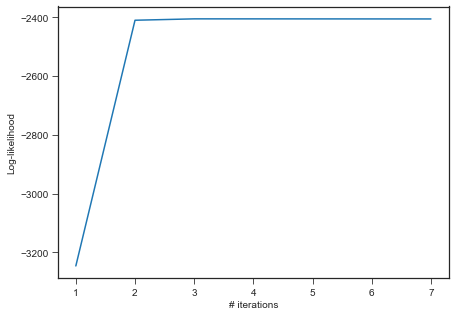

In [5]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=25)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3],
    # prior for the start probabilities
    pi_prior=np.array([5, 1]),
    # type of initialisation to use; can be 'uniform' or 'random'
    init_type='random'
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
    n_iter=100,   # maximum no. of iterations to use
    conv_thresh=1e-04,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
    conv_iter=5,  # no. of iterations for which the convergence criteria should hold before stopping
    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [6]:
hu.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


# Gaussian HMM

Source of example: https://hmmlearn.readthedocs.io/en/0.2.0/auto_examples/plot_hmm_sampling.html#sphx-glr-auto-examples-plot-hmm-sampling-py. 

Consider an HMM with Gaussian emissions, 4 hidden states with specified mean and covariance. The following figure shows shows some samples drawn from the model with the corresponding transitions. 

<img src='img/gauss_hmm_samples.png' width='600'/>

## Setting up the model

The GaussianHMM class uses the following arguments for initialisation:

- *n_states* (int) - the number of hidden states
- *n_emissions* (int) - the number of distinct Gaussian observations
- *params* (string, optional) - controls which parameters are updated in the training process; defaults to all parameters
- *init_params* (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters
- *init_type* (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be 'random' or 'kmeans'
- *covariance_type* (string, optional) - string describing the type of covariance parameters to use.  Must be one of: 'diagonal', 'full', 'spherical' or 'tied'; defaults to 'diagonal'
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'
- *A_prior* (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'
- *means_prior, means_weight* (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means
- *covars_prior, covars_weight* (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix
- *min_covar* (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0
- *verbose* (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training


In [7]:
# instantiate a MultinomialHMM object
my_hmm = GaussianHMM(
    n_states=4,
    n_emissions=2,
    covariance_type='diagonal'
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.6, 0.3, 0.1, 0.0])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6],
    ]
)
# the means of each component
my_hmm.means = np.array([[0.0, 0.0], [0.0, 11.0], [9.0, 10.0], [11.0, -1.0]])

# the covariance of each component - shape depends `covariance_type`
#             (n_states, )                          if 'spherical',
#             (n_states, n_emissions)               if 'diagonal',
#             (n_states, n_emissions, n_emissions)  if 'full'
#             (n_emissions, n_emissions)            if 'tied'
my_hmm.covars = 0.5 * np.ones((4, 2))  # diagonal covariance matrix

hu.pretty_print_hmm(my_hmm, hmm_type='Gaussian')

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.600 | P(S_1)=0.300 | P(S_2)=0.100 | P(S_3)=0.000 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.700 | P(S_1|S_0)=0.200 | P(S_2|S_0)=0.000 | P(S_3|S_0)=0.100 |
| S_1 | P(S_0|S_1)=0.300 | P(S_1|S_1)=0.500 | P(S_2|S_1)=0.200 | P(S_3|S_1)=0.000 |
| S_2 | P(S_0|S_2)=0.000 | P(S_1|S_2)=0.300 | P(S_2|S_2)=0.500 | P(S_3|S_2)=0.200 |
| S_3 | P(S_0|S_3)=0.200 | P(S_1|S_3)=0.000 | P(S_2|S_3)=0.200 | P(S_3|S_3)=0.600 |
+-----+------------------+------------------+------------------+------------------+

## Problem 3

For this task, similarly like in the discrete HMM case, we first generate some observation sequences from the model, after we will create a model, in which the parameters are initialised randomly and try to learn the generator's parameters from the observation sequences.

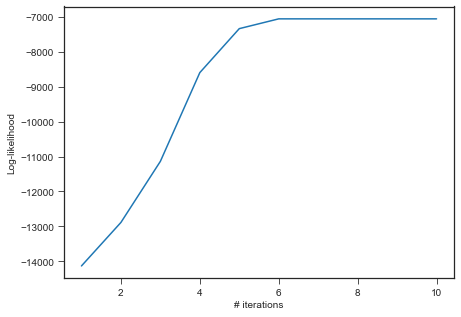

In [8]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=25)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = GaussianHMM(
    # number of hidden states
    n_states=4,
    # number of distinct emissions
    n_emissions=2,
    # can be 'diagonal', 'full', 'spherical', 'tied'
    covariance_type='diagonal',
    verbose=False
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # number of initialisations to perform
    n_iter=100,   # maximum number of iterations to run
    conv_thresh=0.001,  # what percentage of change in the log-likelihood between iterations is considered convergence
    conv_iter=5,  # for how many iterations does it have to hold
    # whether to plot the evolution of the log-likelihood over the iterations
    plot_log_likelihood=True,
    # set to True if want to train until maximum number of iterations is reached
    ignore_conv_crit=False,
    no_init=False,  # set to True if the model parameters shouldn't be re-initialised befor training; in this case they have to be set manually first, otherwise errors occur
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [9]:
hu.pretty_print_hmm(trained_hmm, hmm_type='Gaussian')

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.680 | P(S_1)=0.280 | P(S_2)=0.000 | P(S_3)=0.040 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.651 | P(S_1|S_0)=0.209 | P(S_2|S_0)=0.113 | P(S_3|S_0)=0.027 |
| S_1 | P(S_0|S_1)=0.280 | P(S_1|S_1)=0.459 | P(S_2|S_1)=0.036 | P(S_3|S_1)=0.224 |
| S_2 | P(S_0|S_2)=0.197 | P(S_1|S_2)=0.051 | P(S_2|S_2)=0.507 | P(S_3|S_2)=0.244 |
| S_3 | P(S_0|S_3)=0.048 | P(S_1|S_3)=0.295 | P(S_2|S_3)=0.221 | P(S_3|S_3)=0.436 |
+-----+------------------+------------------+------------------+------------------+

# HMM with labels

## Loading the training data

The Heterogeneous HMM or HMM with labels is helpful when we desire to use an Hidden Markov Model but we want to have different types of distributions managing each of the possible observations.

To illustrate this case, we are gonna train an HMM to manage the activity level of an user (a simple HAR problem) by using data collected from his smartphone. Four different types of data are going to be used during training and prediction:

- Actigraphy data: it is a continuous signal (it is computed by integrating the three axes of the acceleromenter) that represents the movement of the smartphone.

- Light data: it is also a continous signal that represent the ambient light (it is obtainned from the light sensor of the smartphone).

- App usage data: this is a binary signal that represent if the user is using (1) or not (0) the smartphone.

- Fitbit sleep data: this is also a binary signal, where the 1 represent that the fitbit wearable reports that the user is sleep and 0 that he/she is not.

To train the model we have sequences of 24 hours where, at every time instant, we have three different features/observations: the actigraphy, the light and the app usage data points. **It is important to understand that the model, throught the EM algorithm, supports partial or complete missing data**, which means that some of the features or all of them could be missing data points.

*An example of one of the sequences used to train the data can be seen in the next image*: it can be seen that, for the light sensor, most of the data is not available, which will be managed by the model thanks to the missing data support.

<img src='img/heterogeneous_samples.png' width='600'/>

Given the nature of this data, we will use gaussians to manage the actigraphy and light signals and a binary distribution to manage the app usage (if the data had more than two categories, a categorical distribution could be used).

With all this data we are going to train a simple Heterogeneous-HMM (where the labels are the app usage and fitbit data) with two states.


In [10]:
# load the training data - train.pickle contains a dataframe of 10 time series sequences of 286 - 289 observations
# and the preprocessed training sequence list as well
with open('data/train.pickle', 'rb') as f:
    temp = pickle.load(open('data/train.pickle', 'rb'))
    df = temp['all']
    training_seq = temp['tr_seq']
    
df.head()

,seq_no,date,actigraphy,light,app_usage,sleep
0,0,2018-08-05 15:05:30,-0.305134,-0.918191,1,0
1,0,2018-08-05 15:10:32,-0.290736,NaN,1,0
2,0,2018-08-05 15:15:32,-0.595398,NaN,1,0
3,0,2018-08-05 15:20:34,-0.545724,NaN,1,0
4,0,2018-08-05 15:25:34,0.033796,NaN,1,0


## Training the model

The HeterogeneousHMM class uses the following arguments for initialisation:
- *n_states* (int) - the number of hidden states.
- *n_g_emissions* (int) - the number of distinct Gaussian observations.
- *n_d_emissions* (int) - the number of distinct discrete observations.
- *n_d_features* (list - list of the number of possible observable symbols for each discrete emission.
- *params* (string, optional) - controls which parameters are updated in the training process; defaults to all parameters.
- *init_params* (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters.
- *init_type* (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be 'random' or 'kmeans'.
- *nr_no_train_de* (int) - this number indicates the number of discrete emissions whose Matrix Emission Probabilities are fixed and are not trained; it is important to to order the observed variables such that the ones whose emissions aren't trained are the last ones. 
- *state_no_train_de* (int) - a state index for nr_no_train_de which shouldn't be updated; defaults to None, which means that the entire emission probability matrix for that discrete emission will be kept unchanged during training, otherwise the last state_no_train_de states won't be updated
- *covariance_type* (string, optional) - string describing the type of covariance parameters to use.  Must be one of: 'diagonal', 'full', 'spherical' or 'tied'; defaults to 'diagonal'.
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'.
- *A_prior* (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'.
- *means_prior, means_weight* (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means.
- *covars_prior, covars_weight* (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix.
- *min_covar* (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0.
- *verbose* (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training.


We create a model that will have 2 states (just to keep it simple), that will managed 2 features with gaussian distributions and 2 features as discrete observations. With the 'n_d_features' parameter we indicate the model that the two features that we want to manage as discrete are both binary. If, for example, the app usage could take three different values, the 'n_d_features' would be equal to [3,2].

**The model also allows us to fix some of the discrete observations probabilities**: for example, if we want one of the states not to be reachable when the fitbit is equal to 1 (which means that the user is sleeping according to fitbit's data), we can fix the emission probability for one of the states to 1 when fitbit=1 and to 0 in the other case, **we do this  in the next section of code by accesing to my_hmm.B**. *Also, to indicate the model that we want it to not train this last feature, we set 'nr_no_train_de=1'* **(the last 'nr_no_train_de' are not trained but fixed to the original value)**. In case we don´t desire the model to fix certain probabilities of emission, 'nr_no_train_de' must be equal to zero, which means that the model will train all the emission probabilities.

Initialisation 1
iter: 0, log_likelihood = -14580.491880118108, delta = nan
iter: 1, log_likelihood = -6699.06937639869, delta = 7881.422503719418
iter: 2, log_likelihood = -5212.146870043846, delta = 1486.9225063548438
iter: 3, log_likelihood = -5045.278463556426, delta = 166.86840648742054
iter: 4, log_likelihood = -5028.936899553342, delta = 16.341564003083477
iter: 5, log_likelihood = -5027.315864152571, delta = 1.6210354007716887
iter: 6, log_likelihood = -5026.887415884703, delta = 0.42844826786767953
iter: 7, log_likelihood = -5026.589542071902, delta = 0.2978738128012992
iter: 8, log_likelihood = -5026.307954088104, delta = 0.28158798379718064
iter: 9, log_likelihood = -5026.031111226101, delta = 0.2768428620038321
Converged -> iter: 9, log_likelihood = -5026.031111226101


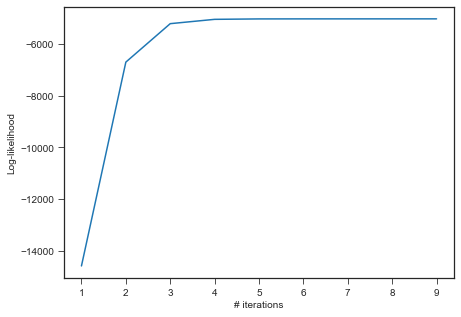

Priors
+--------------+--------------+
|     S_0      |     S_1      |
+--------------+--------------+
| P(S_0)=0.749 | P(S_1)=0.251 |
+--------------+--------------+
Transitions
+-----+------------------+------------------+
|  _  |       S_0        |       S_1        |
+-----+------------------+------------------+
| S_0 | P(S_0|S_0)=0.957 | P(S_1|S_0)=0.043 |
| S_1 | P(S_0|S_1)=0.060 | P(S_1|S_1)=0.940 |
+-----+------------------+------------------+
Means
+-----+--------+--------+
|  _  |  GE_0  |  GE_1  |
+-----+--------+--------+
| S_0 | 0.325  | 0.010  |
| S_1 | -0.452 | -0.099 |
+-----+--------+--------+
Covariances
S_0
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 1.358 | 0.000 |
| GE_1 | 0.000 | 0.191 |
+------+-------+-------+
S_1
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 0.151 | 0.000 |
| GE_1 | 0.000 | 0.007 |
+------+-------+-------+
Emissions
+-----+--------------------+--------------------+
|  

In [12]:
# instantiate a HeterogeneousHMM object
my_hmm = HeterogeneousHMM(
        n_states=2,
        n_g_emissions=2,
        n_d_emissions=2,
        n_d_features=[2, 2],
        covariance_type='diagonal',
        nr_no_train_de=1,
        verbose=True,
    )

# we want to fix the emission probabilities for the sleep parameter, so we need to manually initialise the 
# B matrix before the fitting; so for the first emissions, since we have no prior knowledge on it, we uniformly
# initialise the emission probablities, and for the second one we set it to the desired value
my_hmm.B = [0.5*np.ones((2,2)), np.eye(2)]

# train the model to estimate the parameters
my_hmm, log_likelihood = my_hmm.train(
    training_seq, n_init=1, n_iter=50, conv_thresh=0.001, conv_iter=5, plot_log_likelihood=True,
)

# print model parameters
hu.pretty_print_hmm(my_hmm, hmm_type='Heterogeneous')

As you can see in the previous table, the emission proabilities of the second discrete feature (fitbit data) has been fixed to 0 and 1 values during the training as we indicate with the 'nr_no_train_de' variable during initialization. **It is also possible to partially training the emission probabilities to let the model train the probabilities for certain states while fixing those probability values for the rest of the states**, to do so, the variable **'state_no_train_de'** must be used.

## Sequence decoding

/Users/esukei/Documents/Git/HeterogeneousHMM/lib/heterogeneoushmm/utils.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/Documents/Git/HeterogeneousHMM/lib/heterogeneoushmm/utils.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/Documents/Git/HeterogeneousHMM/lib/heterogeneoushmm/utils.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/Documents/Git/HeterogeneousHMM/lib/heterogeneoushmm/utils.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])


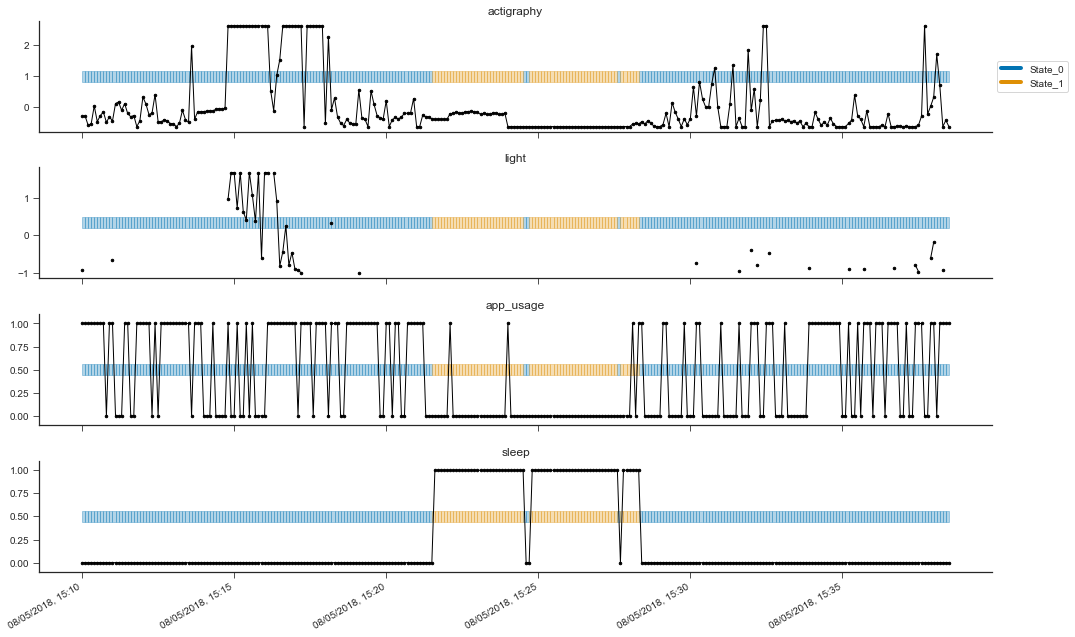

In [13]:
# decode a training sequences
logL, state_seq = my_hmm.decode([training_seq[0]], algorithm='viterbi')

hu.plot_decode(training_seq[0], ['actigraphy', 'light', 'app_usage', 'sleep'], state_seq[0], discrete_columns=['app_usage', 'sleep'],
                time_stamps=df[df['seq_no'] == 0]['date'],figsize=(15, 10))
               

In the previous figure we can observe that the model has clearly associated the state 1 to being sleep because we fixed the emission probabilities to p(state_1 | being_sleep)=1 and p(state_1 | being_awake)=0. This way, we get the model to train the rest of the parameters in order to that state to represent the sleep of the users. If we hadn´t fix those probabilities, the emission probability matrix of both of the state for the sleep feature would have been trained from scratch.